In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [2]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [3]:
def potential(x):
    poten=-10/x
    return poten

In [4]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

La =0
Lb =400
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=30

#离心势能：-k*(l+1)*l/x**2

# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [5]:
l=0
centrifugal_poten=-b_lap*(l+1)*l/grid**2
V_diag=potential(grid)+centrifugal_poten
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num]    
print("real_en",real_en)
print(A)

real_en tensor([-30.9102, -10.3569,  -5.0467,  -2.9510,  -1.9259,  -1.3524,  -1.0004,
         -0.7694,  -0.6099,  -0.4951,  -0.4099,  -0.3448,  -0.2941,  -0.2538,
         -0.2212,  -0.1946,  -0.1724,  -0.1538,  -0.1381,  -0.1247,  -0.1131,
         -0.1031,  -0.0943,  -0.0867,  -0.0799,  -0.0739,  -0.0685,  -0.0637,
         -0.0594,  -0.0555], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5000e+01, -1.2513e+01,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.2513e+01,  1.2505e-02, -1.2513e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.2513e+01,  8.3500e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  2.5000e+01,
         -1.2513e+01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2513e+01,
          2.5000e+01, -1.2513e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.2

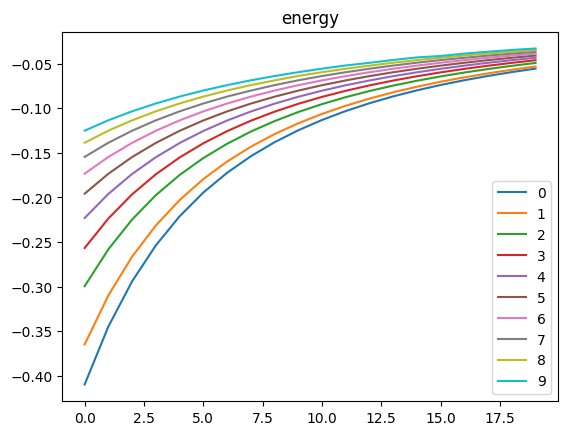

In [8]:
for l in range(10):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num]    
    plt.plot(real_en[10:35].detach().cpu().numpy(),label=str(l))

plt.legend()
plt.title("energy")
plt.show()

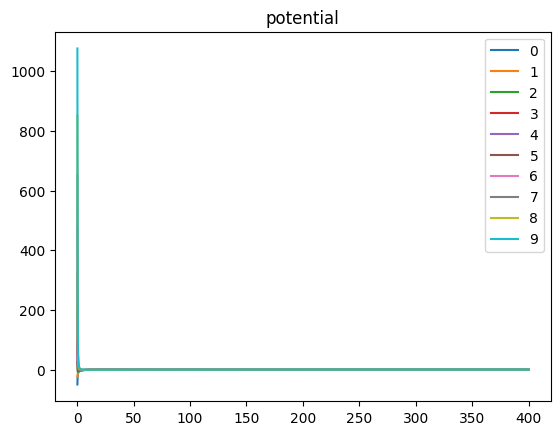

In [7]:
for l in range(10):
    grid=grid[:]
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    plt.plot(grid.detach().cpu().numpy(),V_diag.detach().cpu().numpy(),label=str(l))
plt.legend()
plt.title("potential")
plt.show()